## This Notebook generate TDE lightcurves from MOSFIT, and produces mock observation from LSST OpSIM. It also uses code from Ashley Villar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mosfit
import time
from scipy import integrate
import subprocess
from IPython.display import clear_output
import sys

In [2]:
env_dir = '/d6/CAC/gcontardo/anaconda3/envs/mosfit_lsst/bin/'

In [3]:
# !mkdir /d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products


In [4]:

directory = '/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/'


## Uncomment to generate mosfit data 

In [5]:
# ## Uncomment to generate mosfit data 

# bhmasses = np.logspace(5,8, num=10*3)

# stellmasses = np.arange(0.3, 1.1, 0.1)

# scaledimpact_bs = np.linspace(0,2,10)

# #efficiencies = [0.1] #np.linspace(0.001, 0.4, 10)

# redshifts = np.linspace(0.01, 1, 10)

# counter = 0
# directory = '/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13'
# label = 0
# pd_vals = pd.DataFrame(columns=['bhmass','stellar_mass','scaled_b', 'redshift', 'label'])
# nump_vals = []

# for bhm in bhmasses:
#     for stelm in stellmasses:
#         for scal_b in scaledimpact_bs:
#             #for effi in efficiencies:
#             for z in redshifts:
#                 if counter==20:
                    
#                     time.sleep(50)
#                     counter = 0 
#                     for i in range(label-1, label-11, -1): 
#                         #This removes the extra .json files that we don't need
#                         !rm {directory}/products/tde_*_{i}.json
#                     clear_output(wait=True)
#                     print(label)
#                     #raise Error
                
#                 command = f"{env_dir}mosfit -m tde -S 1000 "
#                 #command += "-x sample_wavelengths seds seds_preextinction rest_times band_indices " # this store all those in extras.json
#                 ## Note this does not have a baked-in limiting mag; assumed this will be handled later on
#                 command += "--extra-bands u g r i z y --extra-instruments LSST --band-sampling-points 295 -F "
#                 command += f"starmass {stelm} Tviscous nhhost b {scal_b} bhmass {bhm} efficiency texplosion 150 lphoto Rph0 codeltatime codeltalambda "
#                 command += f"redshift {z} --suffix {label} --output-path {directory} &"
#                 if label==0:
#                     print(command)
#                 subprocess.call(command, shell=True, stdout=subprocess.DEVNULL,
#                                 stderr=subprocess.STDOUT)
#                 #clear_output(wait=True)
#                 nump_vals.append([bhm,stelm,scal_b, z, label])
#                 pd_vals.loc[label] = [bhm,stelm,scal_b, z, label]
#                 label+=1
#                 counter+=1
# np.save(directory+"/meta_data.npy", np.array(nump_vals))
# pd_vals.to_csv(directory+"/meta_data_panda.csv")

In [6]:
# !mosfit -m tde -e ./astrocatalogs/tde-1980-2025/J030257.json --extra-bands u g r i z y
directory = '/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13'
meta_data = pd.read_csv(directory+"/meta_data_panda.csv")
meta_data#.shape

,Unnamed: 0,bhmass,stellar_mass,scaled_b,redshift,label
0,0,100000.0,0.3,0.0,0.01,0.0
1,1,100000.0,0.3,0.0,0.12,1.0
2,2,100000.0,0.3,0.0,0.23,2.0
3,3,100000.0,0.3,0.0,0.34,3.0
4,4,100000.0,0.3,0.0,0.45,4.0
...,...,...,...,...,...,...
23995,23995,100000000.0,1.0,2.0,0.56,23995.0
23996,23996,100000000.0,1.0,2.0,0.67,23996.0
23997,23997,100000000.0,1.0,2.0,0.78,23997.0
23998,23998,100000000.0,1.0,2.0,0.89,23998.0


## Transforming into LSST light-curves

In [7]:
#!ls -ltrsh /d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/

In [8]:
# !mkdir /d6/CAC/gcontardo/Data/MOSFITS_synth/jan13/lsst_synth

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
#import sqlalchemy 
import random
import json
from collections import OrderedDict
from scipy import interpolate
# from dust_extinction.averages import GCC09_MWAvg
# from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
#from scipy.integrate import simps
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import os

In [10]:

#Define the light curve class
class LightCurve():
    """
    A basic transient model
    """

    def __init__(self, times, obs_mags, mosfitnoisy_mags, filters, snrs, err, mwebv = 0, mosfitphase=None, mosfit_mags=None): #theta?
        """
        Parameters:
        ----------
        ...

        """
        self.times = times
        self.obs_mags = obs_mags
        self.mosfitnoisy_mags = mosfitnoisy_mags
        self.filters = filters
        self.snrs = snrs
        self.errs = err
        #self.theta = theta
        self.mwebv = mwebv
        self.mosfitphase=mosfitphase
        self.mosfit_mags = mosfit_mags 
        ## Now that we are integrating noise from MOSFIT, we might want to keep track of the 3, 
        ## where mosfitmags is the OG returned by mosfit, "mosfitnoisy_mags" is post-noising from MOSFIT but before OpSim
        ## and "obs_mags" is after OpSim/LSST which also has a "noising" step (which, for most observation bright enough, shouldnt be too much)

    def get_df(self):
        ## Return a DataFrame withe time,mag,filter,snr,err
        #print(self.mags)
        #print(self.true_mags)
        df_lc = pd.DataFrame({"timeMJD":self.times, "mags":self.obs_mags, "mosfit_noisymags":self.mosfitnoisy_mags, 
                              "errors":self.errs, "SNRs":self.snrs,
                              "filter":self.filters})
        if self.mosfitphase is not None:
            df_lc['MOSFITday'] = self.mosfitphase
        if self.mosfit_mags is not None:
            df_lc['mosfit_mags']: self.mosfit_mags
            
        return df_lc
        

## If one wants to compare with v3.3
# opsim_file = '/scratch/gcontard/TDE/baseline_v3.3_10yrs.db'

# opsim = os.path.basename(opsim_file).replace('.db','')
# print(opsim)

# # This reads in the OpSim File
# # This file is a database containing many,many pointings of LSST
# conn = sqlite3.connect(opsim_file)    

# #Now in order to read in pandas dataframe we need to know table name
# cursor = conn.cursor()

# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") 
# #proposalId
# df_v3 = pd.read_sql_query('SELECT fieldRA, fieldDec, seeingFwhmEff, observationStartMJD, filter, fiveSigmaDepth, skyBrightness  FROM observations', conn)
# conn.close()


opsim_file = '/d6/CAC/gcontardo/Data/baseline_v4.0_10yrs.db'

opsim = os.path.basename(opsim_file).replace('.db','')
print(opsim)

# This reads in the OpSim File
# This file is a database containing many,many pointings of LSST
conn = sqlite3.connect(opsim_file)    

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") 
#proposalId
df_v4 = pd.read_sql_query('SELECT fieldRA, fieldDec, seeingFwhmEff, observationStartMJD, filter, fiveSigmaDepth, skyBrightness  FROM observations', conn)
conn.close()

baseline_v4.0_10yrs


In [ ]:
df_v

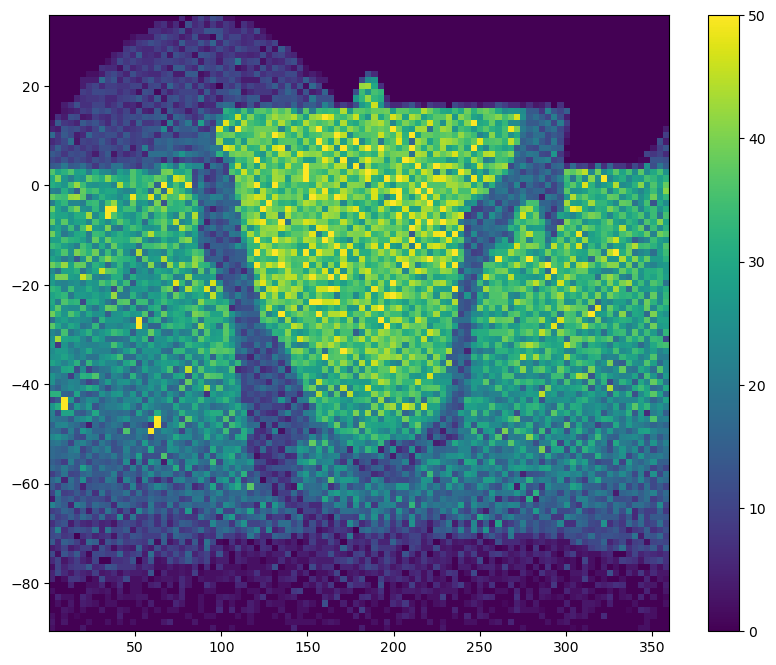

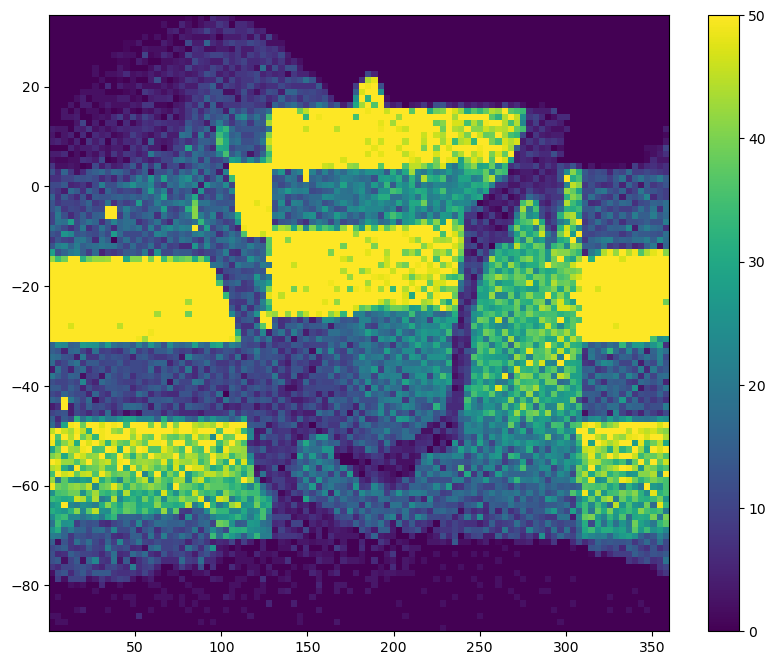

In [11]:
import matplotlib as mpl

## Visualization of the observation strategy for different time periods
mask = (df_v4['observationStartMJD'] > np.min(df_v4['observationStartMJD'])) 
mask = mask & (df_v4['observationStartMJD'] < np.min(df_v4['observationStartMJD'])+ 365*1)

plt.figure(figsize=(10,8))
plt.hist2d(df_v4["fieldRA"][mask], df_v4["fieldDec"][mask], bins=100, vmin=0, vmax=50)#, norm=mpl.colors.LogNorm(),);
plt.colorbar()


mask = (df_v4['observationStartMJD'] > np.min(df_v4['observationStartMJD'])+ 365*1)
mask = mask & (df_v4['observationStartMJD'] < np.min(df_v4['observationStartMJD'])+ 365*2)

plt.figure(figsize=(10,8))
plt.hist2d(df_v4["fieldRA"][mask], df_v4["fieldDec"][mask], bins=100, vmin=0, vmax=50)#, norm=mpl.colors.LogNorm(),);
plt.colorbar()


## We use only the first year of observation to simulate our LSST light-curves

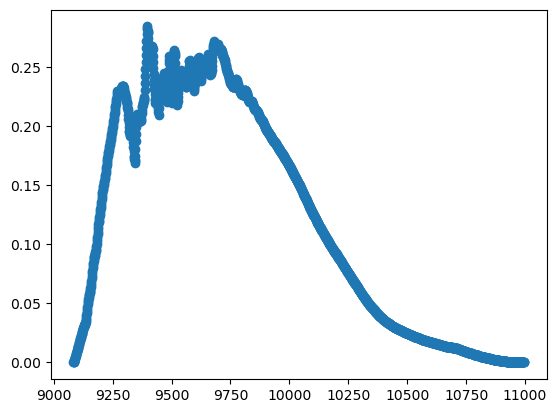

In [12]:
mypath_filters = '/d6/CAC/gcontardo/Data/filters/'

filter_path = mypath_filters+(f'LSST_LSST.y.dat')
blah = np.loadtxt(filter_path)

plt.scatter(blah[:,0], blah[:,1])

## Ashley's code

In [13]:

c_AAs = 2.998e18  # Speed of light in Ångströms per second

band_list = ['u','g','r','i','z','y']
band_wvs = np.asarray([3751.36, 4741.64, 6173.23, 7501.62, 8679.19, 9711.53]) # in angstrom


# This is all to just set up the OpSim Equations
function_list = np.asarray([])
filter_list = np.asarray([])
for band in band_list:
	filter_path = mypath_filters+(f'LSST_LSST.{band}.dat')
	blah = np.loadtxt(filter_path)
	function_list = np.append(function_list,np.trapz(blah[:,1]/blah[:,0],blah[:,0]))
	filter_list = np.append(filter_list,interpolate.interp1d(blah[:,0],blah[:,1],bounds_error=False,fill_value=0.0))
func_dict = {}
bands_and_func = zip(band_list, function_list)
for band, func in bands_and_func:
	func_dict[band] = func
filt_dict = {}
bands_and_filts = zip(band_list, filter_list)
for band, func in bands_and_filts:
	filt_dict[band] = func

# 
keep_LCs = True
tmin = np.min(df_v4['observationStartMJD'])
tmax = np.min(df_v4['observationStartMJD'])+ 365


In [14]:
def get_LSST_sampling_addMOSFITnoise(json_file, df, tmin, tmax, min_datapt=1, shave_time=0):
    ## With a MOSFIT json_file, return a lightcurve sampled according to the observation sim file "df"
    ## where the start date (i.e. where we "paste" the MOSFIT light-curve t0) is between tmin and tmax. 
    ## you probably do not want to touch the min_datapt as it might skew the dataset (I think 1 is fine for our purposes)

    ## NOW we add MOSFIT noise
    
    ## So I pick a lightcurve, and put it somewhere on the sky
    band_list_cln = ['u','g','r','i','z','y']
    
    max_phase=1000 - shave_time
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## 
    ## TODO Check how many real we got for all the TDEs generated, is it always...2?
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea = realiza[0] ## 
    
    times = {b:[] for b in band_list_cln} # 
    truemagsMOS = {b:[] for b in band_list_cln}
    emagsMOS = {b:[] for b in band_list_cln}
    noisymagsMOS = {b:[] for b in band_list_cln}
    
    for x in photo:
        if x['realization']==rea:
            ### This removes some of the "useless" days before the start of the even, if we want that. 
            ### 
            if float(x['time'])>=shave_time:
                times[x['band']].append(float(x['time']))
                truemagsMOS[x['band']].append(float(x['magnitude']))
                emagsMOS[x['band']].append(float(x['e_magnitude']))
                noisymagsMOS[x['band']].append(float(x['magnitude']) +  np.random.normal(0, float(x['e_magnitude'])))
    
    # Have to cheat for the times...
    for b in band_list_cln:
        times[b] = np.arange(len(times[b]))


    
    
    
    # Choose a random start time for the event
    # Everything is in MJD 
    # Let's approximate also all date as int(MJD)
    
    len_db = 0
    
    ## Ensure we have at least min_datapt (right now, anything > 0 flies)
    while len_db<min_datapt: 
    
        start_mjd = random.uniform(tmin, tmax)
        #max_phase = np.max(times['u'])
        
        shifted_times = np.array(times['u']) + np.floor(start_mjd)
        #shifted_times = np.floor(shifted_times).astype('int')
        
        
        ## Put it Somwhere on the sky:
        ## Ideally this should be a location of a galaxy from CatSIM but well...
        
        ra = np.random.uniform(0, 360)
        dec = np.arcsin(np.random.uniform(-1, 1)) * 180 / np.pi
        
        # See if LSST is pointing at this location:
        ## REVERTED BACK TO 3x3 sq degree !!! LSST doc says 3.5?
        
        new_db = df.where((np.abs(df['fieldRA'] - ra) < 3) & 
                          (np.abs(df['fieldDec'] - dec) < 3) & 
                          (df['observationStartMJD'] >= start_mjd) & 
                          (df['observationStartMJD'] < shifted_times[-1])).dropna()
        
        len_db = len(new_db)
        
    #print(len_db)
    # TODO Dust adding at the location (see Ashley's code?)
    ebv = 0 
    ## We don't add dust
        
        
    new_db['MJDint'] = np.floor(new_db['observationStartMJD'].values).astype(int)
    new_db['deshifted_MJD'] = new_db['MJDint'] - np.floor(start_mjd) ##should be rightish?
    
    #reddened_mags = np.zeros(np.shape(mags))
    times_lsst = {b:[] for b in band_list_cln} # Or use the LightCurve object Ashley made?
    mags_lsst = {b:[] for b in band_list_cln}
    alllsst_mags = np.zeros(len(new_db))
    allmosfit_mags = np.zeros(len(new_db))
    
    for bandcounter, myband in enumerate(band_list_cln):
        gind2 = np.where(new_db['filter'] == myband)

        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # WE DO NOT redden or anything, (assuming we'll have corrected for this?!)
        
        #reddened_mags[:, bandcounter] = mags[:, bandcounter] #+ ext_list[bandcounter] + host_ext_list[bandcounter]
    
        # Resample to match LSST cadence
        # Ashley interpolate to get the value at the exact timevalue, but I think we can probably take the day?     
        #new_model_mags = my_model_function(new_db['observationStartMJD'].where(new_db['filter'] == myband).dropna().values)
        #lsst_mags[gind2] = new_model_mags
    
        ## Sometimes there is more than one observation per day... Not sure how to aggregate those. 
        ## I think we keep all of them ? 
        times_lsst[myband] = np.unique(new_db['MJDint'].values[gind2])
        #try:
        mags_lsst[myband] = np.array(noisymagsMOS[myband])[np.where(np.isin(shifted_times, new_db.iloc[gind2]['MJDint'].values))[0]]

        alllsst_mags[gind2] = np.array([np.array(noisymagsMOS[myband])[shifted_times==ti] for ti in new_db.iloc[gind2]['MJDint']]).reshape(-1)
        allmosfit_mags[gind2] = np.array([np.array(truemagsMOS[myband])[shifted_times==ti] for ti in new_db.iloc[gind2]['MJDint']]).reshape(-1)
        

    #mags_lsst : downsampled lc from MOSFIT, with times_lsst
        
    ## Ashley has code that adds noise:
    ## This assumes magnitude in AB 
    
    g = 2.2
    h = 6.626e-27
    expTime = 30.0
    my_integrals = 10. ** (-0.4 * (alllsst_mags + 48.6)) * [func_dict.get(key) for key in 
                                                            new_db['filter'].values]
    
    C = expTime * np.pi * 321.15**2 / g / h * my_integrals
    fwhmeff = new_db['seeingFwhmEff'].values
    pixscale = 0.2  # ''/pixel
    neff = 2.266 * (fwhmeff / pixscale)**2
    sig_in = 12.7
    neff = 2.266 * (new_db['seeingFwhmEff'].values / pixscale)**2
    my_integrals = 10. ** (-0.4 * (new_db['skyBrightness'].values + 48.6)) * [func_dict.get(key) for
                                                                              key in new_db['filter'].values]
    B = expTime * np.pi * 321.15**2 / g / h * my_integrals * (pixscale)**2
    snr = C / np.sqrt(C / g + (B / g + sig_in**2) * neff)

    # We do not cap the SNRs anymore    
    # gind_snr = np.where(snr > 20)
    # snr[gind_snr] = 20
    # gind_snr = np.where(snr < 0.0001)
    # snr[gind_snr] = 0.0001
    
    with np.errstate(divide='ignore'):
        err = 1.09 / snr
        
    
    alllsst_mags_noise = alllsst_mags + np.random.normal(0, err)
    
    
    mylc = LightCurve(new_db['observationStartMJD'].values, obs_mags=alllsst_mags_noise, mosfitnoisy_mags=alllsst_mags, 
                     filters= new_db['filter'].values, snrs=snr, err= err, mwebv=ebv,
                      mosfitphase=new_db['deshifted_MJD'].values,
                      mosfit_mags=allmosfit_mags)

    return mylc.get_df() #, times,magsMOS, times_lsst, mags_lsst

In [15]:
df_tdes = pd.read_csv("/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/meta_data_panda.csv")

In [21]:
# !mkdir /d6/CAC/gcontardo/Data/MOSFITS_synth/apr13/lsst_synth_mosfitnoise_shavedT120/

## Uncomment below to create LSST synthetic

## One might want to apply the limiting magnitude cut HERE?

In [16]:


# dir_lsst = "/d6/CAC/gcontardo/Data/MOSFITS_synth/apr13/lsst_synth_mosfitnoise_shavedT120/"
# list_miss = []
# for i in range(len(df_tdes)):
#     json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{int(df_tdes["label"].iloc[i])}.json"
#     if i % 100 == 0:
#         print(json_Tde)

#     try:
#         dflc = get_LSST_sampling_addMOSFITnoise(json_Tde, df_v4,tmin,tmax, min_datapt=1, shave_time=120)
#         ## Do we want this min-dtapt thing? I realize I ran the previous with min-datapt = 10.
#         ## I think as long as we don't use THIS dataset to make assumptions on tDE detected we're good. 
#         ##
#         dflc.to_csv(dir_lsst+f"synth_tde_{int(df_tdes["label"].iloc[i])}.csv")
#         #break
#         del dflc
#     except FileNotFoundError:
#         print(f"{i} is missing?")
#         list_miss.append(i)

/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_0.json
17 is missing?
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_100.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_400.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_500.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_600.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_700.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_800.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_900.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_1000.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_1100.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_1200.json
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_1300.json
1355 is missing?
1356 is missing?
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_1400.json
1407 is missing?
1493 is missing?
/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_1500.json
/d6

# Check a light-curve

### Note that because we haven't applied a limiting magnitude some points should definitely be thrown away
(we do it using the errors now)

In [29]:
json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{40}.json"




dflc = get_LSST_sampling_keepMOSFITtime(json_Tde, df_v4,tmin,tmax, min_datapt=30)
dflc

,timeMJD,mags,truemags,errors,SNRs,filter,MOSFITday
0,61020.354657,-1157.956738,34.289908,10753.130620,0.000101,z,43.0
1,61027.322520,761.204774,34.127337,2923.664384,0.000373,i,50.0
2,61028.330663,-5883.592311,34.289908,7300.473275,0.000149,z,51.0
3,61031.332026,-962.446662,33.907119,1592.058533,0.000685,r,54.0
4,61032.328102,2366.454801,33.907119,1937.954550,0.000562,r,55.0
...,...,...,...,...,...,...,...
247,61918.962224,18.466311,18.461021,0.004575,238.265920,z,941.0
248,61920.026331,18.296857,18.300562,0.003266,333.728424,i,943.0
249,61920.050450,18.460871,18.466912,0.005257,207.328468,z,943.0
250,61920.997176,18.298183,18.300562,0.003151,345.902436,i,943.0


In [30]:
# plt.hist(dflc['errors']);

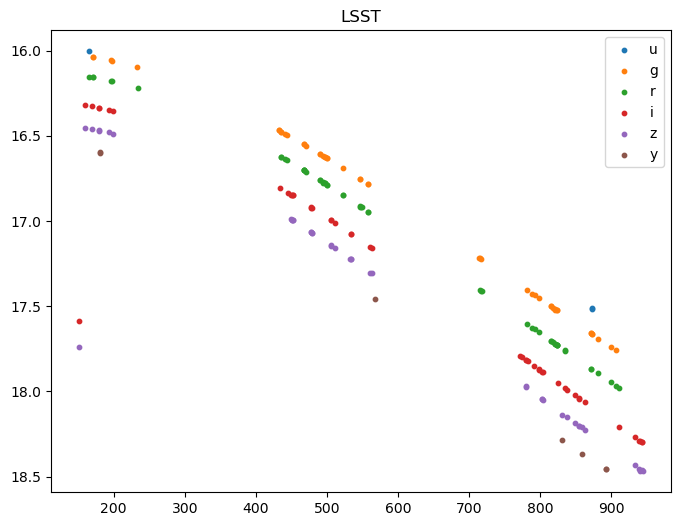

In [31]:
json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{40}.json"

band_list_cln =  ['u','g','r','i','z','y']

lim_mag = 23.5

times,magsMOS, mags_lsst = dflc['MOSFITday'], dflc['truemags'],dflc['mags']


mask_mag = dflc['truemags']<23


plt.figure(figsize=(8,6))
for b in band_list_cln:
    mask = dflc['filter']==b
    plt.scatter(times[mask & mask_mag], mags_lsst[mask & mask_mag], s=10, label=b)
plt.gca().invert_yaxis()
plt.title("LSST")
plt.legend()